# Imports

In [91]:
import os
import sys
import tempfile
import time
from collections import deque
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow
import torch
import torch.nn as nn
from matplotlib import cm
from torch.utils.data import DataLoader

In [7]:
DEBUG = "CI" in os.environ

In [8]:
if DEBUG:
    %load_ext autoreload
    %autoreload 2

In [9]:
import proteinsolver
import proteinsolver.datasets

In [216]:
%matplotlib inline

try:
    inline_rc
except NameError:
    inline_rc = mpl.rcParams.copy()
    
mpl.rcParams.update({"font.size": 12})

# Datasets

In [11]:
DATA_ROOT = Path(tempfile.gettempdir())
DATA_ROOT = Path("/home/strokach/ml_data")
DATA_ROOT.mkdir(exist_ok=True)
DATA_ROOT

PosixPath('/home/strokach/ml_data')

In [12]:
NOTEBOOK_NAME = "sudoku_analysis"
NOTEBOOK_PATH = Path(NOTEBOOK_NAME)
NOTEBOOK_PATH.mkdir(exist_ok=True)
NOTEBOOK_PATH

PosixPath('sudoku_analysis')

## Sudoku

In [13]:
sudoku_dataset_train = proteinsolver.datasets.SudokuDataset3(root=DATA_ROOT.joinpath("sudoku_train"))

In [14]:
sudoku_dataset_valid = proteinsolver.datasets.SudokuDataset2(root=DATA_ROOT.joinpath("sudoku_valid"), subset="sudoku_valid")

In [15]:
sudoku_dataset_test = proteinsolver.datasets.SudokuDataset2(root=DATA_ROOT.joinpath("sudoku_test"), subset="sudoku_test")

# Training plots

In [16]:
training_logs = {}

In [17]:
df = pd.read_csv("sudoku_4xEdgeConv.bak/training.log", sep=' +', engine='python')
df = df[df["datapoint"] != "datapoint"]

for c in ["step", "datapoint"]:
    df[c] = df[c].astype(np.int)

for c in ["avg_loss", "accuracy", "accuracy_m", "accuracy_mv", "time_elapsed"]:
    df[c] = df[c].astype(np.float)

training_logs["sudoku_4xEdgeConv_bs4"] = df
training_logs["sudoku_4xEdgeConv_bs4"].head(2)

#
datapoint_offsets = np.zeros(len(training_logs["sudoku_4xEdgeConv_bs4"]))

prev_datapoint = 0
cur_offset = 0
for i, datapoint in enumerate(training_logs["sudoku_4xEdgeConv_bs4"]["datapoint"]):
    if datapoint <= prev_datapoint:
        cur_offset += prev_datapoint
    prev_datapoint = datapoint
    datapoint_offsets[i] = cur_offset

training_logs["sudoku_4xEdgeConv_bs4"]["datapoint"] += datapoint_offsets

assert (training_logs["sudoku_4xEdgeConv_bs4"]["datapoint"].value_counts() == 1).all()

In [18]:
training_logs["sudoku_4xEdgeConv"] = pd.read_csv("sudoku_4xEdgeConv/training.log", skiprows=1)
training_logs["sudoku_5xEdgeConv_uniform"] = pd.read_csv("sudoku_5xEdgeConv_uniform/training.log", skiprows=1)
training_logs["sudoku_4xEdgeConv_stretch"] = pd.read_csv("sudoku_4xEdgeConv_stretch/training.log", skiprows=1)
training_logs["sudoku_4xEdgeConv_p05"] = pd.read_csv("sudoku_4xEdgeConv_p05/training.log", skiprows=1)

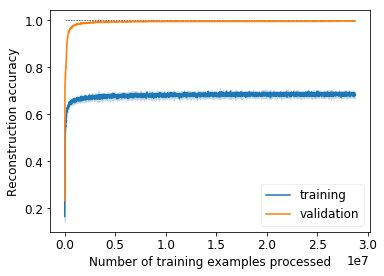

In [58]:
#### window = 30
df = training_logs["sudoku_4xEdgeConv_stretch"]

cmap = cm.get_cmap("tab10")

fg, ax = plt.subplots(figsize=(5.5, 4))
x = df["datapoint"]
accuracy_m_mean, accuracy_m_std = df["accuracy_m"].rolling(window=4, min_periods=0).agg(['mean', 'std']).values.T
accuracy_mv_mean, accuracy_mv_std = df["accuracy_mv"].rolling(window=4, min_periods=0).agg(['mean', 'std']).values.T
#     accuracy_m_mean = df["accuracy_m"]
#     accuracy_mv_mean = df["accuracy_mv"]
ax.plot(x, accuracy_m_mean, label="training", color=cmap(0))
ax.fill_between(x, accuracy_m_mean - accuracy_m_std, accuracy_m_mean + accuracy_m_std, alpha=0.25, color=cmap(0))
ax.plot(x, accuracy_mv_mean, label="validation", color=cmap(1))
ax.fill_between(x, accuracy_mv_mean - accuracy_mv_std, accuracy_mv_mean + accuracy_mv_std, alpha=0.25, color=cmap(1))
#     ax.set_ylim(0.5, 1.005)
ax.hlines(1, min(x), max(x), linestyle='--', linewidth=0.5)
ax.set_xlabel("Number of training examples processed")
ax.set_ylabel("Reconstruction accuracy")
ax.ticklabel_format(axis="x", style="scientific", scilimits=(0, 0))
ax.legend(framealpha=0.3, loc="lower right")
fg.tight_layout()
fg.savefig(NOTEBOOK_PATH / "training_curve.svg")
fg.savefig(NOTEBOOK_PATH / "training_curve.pdf")
fg.savefig(NOTEBOOK_PATH / "training_curve.png", dpi=300)

# Validation plots

# Models

In [37]:
import torch
import torch.nn.functional as F
from torch import optim
from torch_geometric.data import DataLoader
from torch_geometric.nn import ChebConv, EdgeConv, GATConv, GCNConv
from torch_geometric.nn.inits import reset
from torch_geometric.utils import add_self_loops, remove_self_loops, scatter_

In [38]:
class EdgeConvMod(torch.nn.Module):
    def __init__(self, nn, aggr="max"):
        super().__init__()
        self.nn = nn
        self.aggr = aggr
        self.reset_parameters()

    def reset_parameters(self):
        reset(self.nn)

    def forward(self, x, edge_index, edge_attr=None):
        """"""
        row, col = edge_index
        x = x.unsqueeze(-1) if x.dim() == 1 else x

        # TODO: Try -x[col] instead of x[col] - x[row]
        if edge_attr is None:
            out = torch.cat([x[row], x[col] - x[row]], dim=-1)
        else:
            out = torch.cat([x[row], x[col] - x[row], edge_attr], dim=-1)
        out = self.nn(out)
        x = scatter_(self.aggr, out, row, dim_size=x.size(0))

        return x, out

    def __repr__(self):
        return "{}(nn={})".format(self.__class__.__name__, self.nn)

In [39]:
class EdgeConvBatch(nn.Module):
    def __init__(self, gnn, hidden_size, batch_norm=True, dropout=0.2):
        super().__init__()

        self.gnn = gnn

        x_post_modules = []
        edge_attr_post_modules = []

        if batch_norm is not None:
            x_post_modules.append(nn.BatchNorm1d(hidden_size))
            edge_attr_post_modules.append(nn.BatchNorm1d(hidden_size))

        if dropout:
            x_post_modules.append(nn.Dropout(dropout))
            edge_attr_post_modules.append(nn.Dropout(dropout))

        self.x_postprocess = nn.Sequential(*x_post_modules)
        self.edge_attr_postprocess = nn.Sequential(*edge_attr_post_modules)

    def forward(self, x, edge_index, edge_attr=None):
        x, edge_attr = self.gnn(x, edge_index, edge_attr)
        x = self.x_postprocess(x)
        edge_attr = self.edge_attr_postprocess(edge_attr)
        return x, edge_attr

In [40]:
def get_graph_conv_layer(input_size, hidden_size, output_size):
    mlp = nn.Sequential(
        #
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, output_size),
    )
    gnn = EdgeConvMod(nn=mlp, aggr="add")
    graph_conv = EdgeConvBatch(gnn, output_size, batch_norm=True, dropout=0.2)
    return graph_conv

In [41]:
class Net(nn.Module):
    def __init__(self, x_input_size, adj_input_size, hidden_size, output_size):
        super().__init__()

        self.embed_x = nn.Sequential(
            nn.Embedding(x_input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
        )

        if adj_input_size:
            self.embed_adj = nn.Sequential(
                nn.BatchNorm1d(adj_input_size),
                nn.Linear(adj_input_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
            )
        else:
            self.embed_adj = None

        self.graph_conv_1 = get_graph_conv_layer((2 + bool(adj_input_size)) * hidden_size, 2 * hidden_size, hidden_size)
        self.graph_conv_2 = get_graph_conv_layer(3 * hidden_size, 2 * hidden_size, hidden_size)
        self.graph_conv_3 = get_graph_conv_layer(3 * hidden_size, 2 * hidden_size, hidden_size)
        self.graph_conv_4 = get_graph_conv_layer(3 * hidden_size, 2 * hidden_size, hidden_size)
#         self.graph_conv_5 = get_graph_conv_layer(3 * hidden_size, 2 * hidden_size, hidden_size)
        self.linear_out = nn.Linear(hidden_size, output_size)

    def forward(self, x, edge_index, edge_attr=None):

        x = self.embed_x(x)
        edge_index, _ = remove_self_loops(edge_index)  # We should remove self loops in this case!
        edge_attr = self.embed_adj(edge_attr) if edge_attr is not None else None

        x_out, edge_attr_out = self.graph_conv_1(x, edge_index, edge_attr)
        x += x_out
        edge_attr = (edge_attr + edge_attr_out) if edge_attr is not None else edge_attr_out

        x = F.relu(x)
        edge_attr = F.relu(edge_attr)
        x_out, edge_attr_out = self.graph_conv_2(x, edge_index, edge_attr)
        x += x_out
        edge_attr += edge_attr_out

        x = F.relu(x)
        edge_attr = F.relu(edge_attr)
        x_out, edge_attr_out = self.graph_conv_3(x, edge_index, edge_attr)
        x += x_out
        edge_attr += edge_attr_out

        x = F.relu(x)
        edge_attr = F.relu(edge_attr)
        x_out, edge_attr_out = self.graph_conv_4(x, edge_index, edge_attr)
        x += x_out
        edge_attr += edge_attr_out

#         x = F.relu(x)
#         edge_attr = F.relu(edge_attr)
#         x_out, edge_attr_out = self.graph_conv_5(x, edge_index, edge_attr)
#         x += x_out
#         edge_attr += edge_attr_out

        x = self.linear_out(x)
        return x

## Validation

In [42]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
# device = "cpu"
device

device(type='cuda', index=2)

In [43]:
net = Net(x_input_size=10, adj_input_size=None, hidden_size=128, output_size=9)
net.load_state_dict(torch.load("sudoku_4xEdgeConv_stretch/e27-s210924-d26998272-amv09968.state"))
net.eval()
net = net.to(device)

### Oneshot

In [221]:
results = []
for i, data in enumerate(
    DataLoader(sudoku_dataset_valid[:10_000], shuffle=False, num_workers=4, batch_size=1, drop_last=False)
):
    if (i + 1) % 1000 == 0:
        print(i + 1)
    data = data.to(device)
    is_missing = data.x == 9
    output = net(data.x, data.edge_index)
    output = torch.softmax(output, dim=1)
    _, predicted = output.max(dim=1)
    num_correct = float((predicted[is_missing] == data.y[is_missing]).sum())
    num_total = float(is_missing.sum())
    results.append({"fraction_correct": num_correct / num_total, "num_correct": num_correct, "num_total": num_total})
results_df = pd.DataFrame(results)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


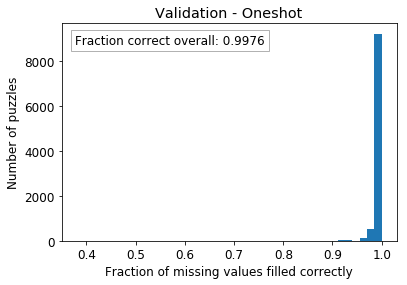

In [223]:
xlim = (0.35, 1.03)
textstr = """\
Fraction correct overall: {:.4f}
""".format(
    results_df["num_correct"].sum() / results_df["num_total"].sum()
).strip()
props = dict(facecolor="white", alpha=0.3)

with plt.rc_context(rc={"font.size": 12}):
    fg, ax = plt.subplots(figsize=(6, 4))
    data = results_df["fraction_correct"]
    assert data.min() >= xlim[0] and data.max() <= xlim[1]
    ax.hist(data)
    ax.set_ylabel("Number of puzzles")
    ax.set_xlabel("Fraction of missing values filled correctly")
    ax.set_xlim(*xlim)
    #     ax.set_ylim(0, 5)
    ax.set_title("Validation - Oneshot")
    ax.text(0.04, 0.95, textstr, transform=ax.transAxes, fontsize="medium", verticalalignment="top", bbox=props)
fg.savefig(NOTEBOOK_PATH / "validation-oneshot.svg")
fg.savefig(NOTEBOOK_PATH / "validation-oneshot.pdf")
fg.savefig(NOTEBOOK_PATH / "validation-oneshot.png", dpi=300)

### Incremental

In [224]:
@torch.no_grad()
def design_sudoku(net, x, edge_index):
    mask = (x == 9)
    if not mask.any():
        return x
    output = net(x, edge_index)
    output = torch.softmax(output, dim=1)
    max_pred, max_index = output.max(dim=1)
    max_pred[~mask] = -1
    _, max_residue = max_pred.max(dim=0)
    x[max_residue] = max_index[max_residue]
    return design_sudoku(net, x, edge_index)

In [225]:
results = []
for i, data in enumerate(
    DataLoader(sudoku_dataset_valid[:10_000], shuffle=False, num_workers=4, batch_size=1, drop_last=False)
):
    if (i + 1) % 1000 == 0:
        print(i + 1)
    data = data.to(device)
    x_in = data.x.clone()
    is_missing = x_in == 9
    predicted = design_sudoku(net, x_in, data.edge_index)
    num_correct = float((predicted[is_missing] == data.y[is_missing]).sum())
    num_total = float(is_missing.sum())
    results.append({"fraction_correct": num_correct / num_total, "num_correct": num_correct, "num_total": num_total})
results_df = pd.DataFrame(results)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


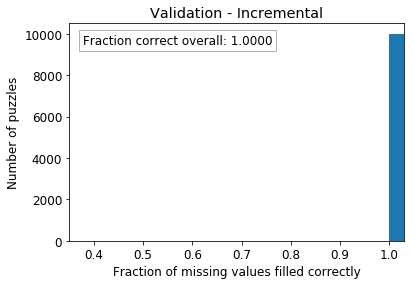

In [227]:
xlim = (0.35, 1.03)
textstr = """\
Fraction correct overall: {:.4f}
""".format(
    results_df["num_correct"].sum() / results_df["num_total"].sum()
).strip()
props = dict(facecolor="white", alpha=0.3)

with plt.rc_context(rc={"font.size": 12}):
    fg, ax = plt.subplots(figsize=(6, 4))
    data = results_df["fraction_correct"]
    assert data.min() >= xlim[0] and data.max() <= xlim[1]
    ax.hist(data, bins=20)
    ax.set_ylabel("Number of puzzles")
    ax.set_xlabel("Fraction of missing values filled correctly")
    ax.set_xlim(*xlim)
#     ax.set_ylim(0, 5)
    ax.set_title("Validation - Incremental")
    ax.text(0.04, 0.95, textstr, transform=ax.transAxes, fontsize="medium", verticalalignment="top", bbox=props)
fg.savefig(NOTEBOOK_PATH / "validation-incremental.svg")
fg.savefig(NOTEBOOK_PATH / "validation-incremental.pdf")
fg.savefig(NOTEBOOK_PATH / "validation-incremental.png", dpi=300)

## Test dataset

In [226]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
# device = "cpu"
device

device(type='cuda', index=2)

In [227]:
net = Net(x_input_size=10, adj_input_size=None, hidden_size=128, output_size=9)
# net.load_state_dict(torch.load("sudoku_4xEdgeConv_stretch/e0-s7812-d999936-amv09791666666666666.state"))
net.load_state_dict(torch.load("sudoku_4xEdgeConv_stretch/e27-s210924-d26998272-amv09968.state"))

net.eval()
net = net.to(device)

### Oneshot

In [251]:
results = []
for data in sudoku_dataset_test:
    data = data.to(device)
    is_missing = data.x == 9
    output = net(data.x, data.edge_index)
    output = torch.softmax(output, dim=1)
    _, predicted = output.max(dim=1)
    num_correct = float((predicted[is_missing] == data.y[is_missing]).sum())
    num_total = float(is_missing.sum())
    results.append({"fraction_correct": num_correct / num_total, "num_correct": num_correct, "num_total": num_total})
oneshot_results_df = pd.DataFrame(results)

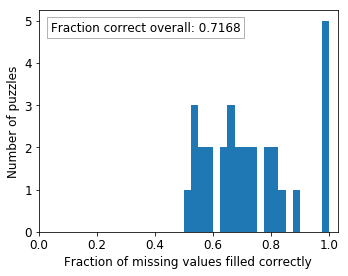

In [255]:
xlim = (0, 1.03)
textstr = """\
Fraction correct overall: {:.4f}
""".format(
    oneshot_results_df["num_correct"].sum() / oneshot_results_df["num_total"].sum()
).strip()
props = dict(facecolor="white", alpha=0.3)

fg, ax = plt.subplots(figsize=(5, 4))
data = oneshot_results_df["fraction_correct"]
assert data.min() >= xlim[0] and data.max() <= xlim[1]
ax.hist(data, bins=20)
ax.set_ylabel("Number of puzzles")
ax.set_xlabel("Fraction of missing values filled correctly")
ax.set_xlim(*xlim)
#     ax.set_ylim(0, 5)
# ax.set_title("Test - Oneshot")
ax.text(0.04, 0.95, textstr, transform=ax.transAxes, fontsize="medium", verticalalignment="top", bbox=props)
fg.tight_layout()
fg.savefig(NOTEBOOK_PATH / "test-oneshot.svg")
fg.savefig(NOTEBOOK_PATH / "test-oneshot.pdf")
fg.savefig(NOTEBOOK_PATH / "test-oneshot.png", dpi=300)

### Incremental

In [256]:
@torch.no_grad()
def design_sudoku(net, x, edge_index, log_conf_lst=None):
    mask = (x == 9)
    if not mask.any():
        return x
    
    index_array = torch.arange(x.size(0))
    
    output = net(x, edge_index)
    output = output[mask]
    index_array = index_array[mask]

    max_pred, max_index = torch.softmax(output, dim=1).max(dim=1)

    _, max_residue = max_pred.max(dim=0)
    if log_conf_lst is not None:
        log_conf_lst.append(torch.log(max_pred[max_residue]).data.cpu())

    assert x[index_array[max_residue]] == 9
    x[index_array[max_residue]] = max_index[max_residue]
    return design_sudoku(net, x, edge_index, log_conf_lst)

In [257]:
net = Net(x_input_size=10, adj_input_size=None, hidden_size=128, output_size=9)
# net.load_state_dict(torch.load("sudoku_4xEdgeConv_stretch/e0-s7812-d999936-amv09791666666666666.state"))
net.load_state_dict(torch.load("sudoku_4xEdgeConv_stretch/e27-s210924-d26998272-amv09968.state"))

net.eval()
net = net.to(device)

wrong_preds = []
results = []
for data in sudoku_dataset_test:
    data = data.to(device)
    x_in = data.x.clone()
    is_missing = x_in == 9
    log_conf_lst = []
    predicted = design_sudoku(net, x_in, data.edge_index, log_conf_lst)
    num_correct = float((predicted[is_missing] == data.y[is_missing]).sum())
    num_total = float(is_missing.sum())
    results.append(
        {
            "fraction_correct": num_correct / num_total,
            "num_correct": num_correct,
            "num_total": num_total,
            "sum_log_prob": np.sum(log_conf_lst),
        }
    )
    if num_correct < num_total:
        wrong_preds.append(
            (
                data.x.data.cpu().numpy(),
                data.edge_index.data.cpu().numpy(),
                data.y.data.cpu().numpy(),
                predicted.data.cpu().numpy(),
            )
        )
results_df = pd.DataFrame(results)
print(results_df["num_correct"].sum() / results_df["num_total"].sum())

0.9400510204081632


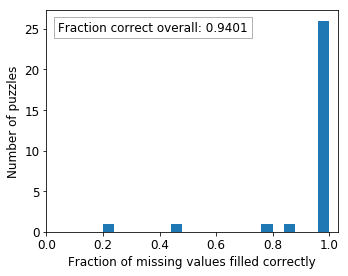

In [260]:
xlim = (0, 1.03)
textstr = """\
Fraction correct overall: {:.4f}
""".format(
    results_df["num_correct"].sum() / results_df["num_total"].sum()
).strip()
props = dict(facecolor="white", alpha=0.3)

fg, ax = plt.subplots(figsize=(5, 4))
data = results_df["fraction_correct"]
assert data.min() >= xlim[0] and data.max() <= xlim[1]
ax.hist(data, bins=20)
ax.set_ylabel("Number of puzzles")
ax.set_xlabel("Fraction of missing values filled correctly")
ax.set_xlim(*xlim)
#     ax.set_ylim(0, 5)
# ax.set_title("Test - Incremental")
ax.text(0.04, 0.95, textstr, transform=ax.transAxes, fontsize="medium", verticalalignment="top", bbox=props)
fg.tight_layout()
fg.savefig(NOTEBOOK_PATH / "test-incremental.svg", bbox_inches="tight")
fg.savefig(NOTEBOOK_PATH / "test-incremental.pdf", bbox_inches="tight")
fg.savefig(NOTEBOOK_PATH / "test-incremental.png", dpi=300, bbox_inches="tight")

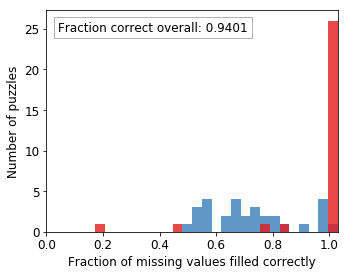

In [271]:
xlim = (0, 1.03)
textstr = """\
Fraction correct overall: {:.4f}
""".format(
    results_df["num_correct"].sum() / results_df["num_total"].sum()
).strip()
props = dict(facecolor="white", alpha=0.3)


fg, ax = plt.subplots(figsize=(5, 4))

data = oneshot_results_df["fraction_correct"]
assert data.min() >= xlim[0] and data.max() <= xlim[1]
ax.hist(data, bins=30, range=xlim, alpha=0.8, label="oneshot", color=cm.get_cmap("Set1")(1))

data = results_df["fraction_correct"]
assert data.min() >= xlim[0] and data.max() <= xlim[1]
ax.hist(data, bins=30, range=xlim, alpha=0.8, label="incremental", color=cm.get_cmap("Set1")(0))

ax.set_ylabel("Number of puzzles")
ax.set_xlabel("Fraction of missing values filled correctly")
ax.set_xlim(*xlim)
#     ax.set_ylim(0, 5)
# ax.set_title("Test - Incremental")
ax.text(0.04, 0.95, textstr, transform=ax.transAxes, fontsize="medium", verticalalignment="top", bbox=props)
fg.tight_layout()
fg.savefig(NOTEBOOK_PATH / "test-oneshot_incremental.svg", bbox_inches="tight")
fg.savefig(NOTEBOOK_PATH / "test-oneshot_incremental.pdf", bbox_inches="tight")
fg.savefig(NOTEBOOK_PATH / "test-oneshot_incremental.png", dpi=300, bbox_inches="tight")

In [242]:
import torch_geometric
torch_geometric.utils.sparse_to_dense(torch.tensor(wrong_preds[0][1]))

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

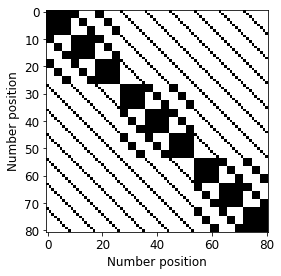

In [235]:
mpl.rcParams.update({"font.size": 12})

fg, ax = plt.subplots(figsize=(5.5, 4))
ax.imshow(torch_geometric.utils.sparse_to_dense(torch.tensor(wrong_preds[0][1])), cmap="Greys")
# ax.colorbar()
ax.set_xlabel("Number position")
ax.set_ylabel("Number position")
fg.tight_layout()
fg.savefig(NOTEBOOK_PATH.joinpath("sudoku_adjacency.svg"), bbox_inches="tight")
fg.savefig(NOTEBOOK_PATH.joinpath("sudoku_adjacency.pdf"), bbox_inches="tight")
fg.savefig(NOTEBOOK_PATH.joinpath("sudoku_adjacency.png"), bbox_inches="tight", dpi=300)

In [219]:
def plot_sudoku(puzzle, solved=None, pred=None, ax=None):
    # Simple plotting statement that ingests a 9x9 array (n), and plots a sudoku-style grid around it.
    if ax is None:
        _, ax = plt.subplots()

    for y in range(10):
        ax.plot([-0.05, 9.05], [y, y], color="black", linewidth=1)

    for y in range(0, 10, 3):
        ax.plot([-0.05, 9.05], [y, y], color="black", linewidth=3)

    for x in range(10):
        ax.plot([x, x], [-0.05, 9.05], color="black", linewidth=1)

    for x in range(0, 10, 3):
        ax.plot([x, x], [-0.05, 9.05], color="black", linewidth=3)

    ax.axis("image")
    ax.axis("off")  # drop the axes, they're not important here

    for x in range(9):
        for y in range(9):
            puzzle_element = puzzle[8 - y][x]  # need to reverse the y-direction for plotting
            if puzzle_element > 0:  # ignore the zeros
                T = f"{puzzle_element}"
                ax.text(x + 0.3, y + 0.2, T, fontsize=20)
            elif solved is not None and pred is not None:
                solved_element = solved[8 - y][x]
                pred_element = pred[8 - y][x]
                if solved_element == pred_element:
                    T = f"{solved_element}"
                    ax.text(x + 0.3, y + 0.2, T, fontsize=20, color="b")
                else:
                    ax.text(x + 0.1, y + 0.3, f"{pred_element}", fontsize=13, color="r")
                    ax.text(x + 0.55, y + 0.3, f"{solved_element}", fontsize=13, color="g")

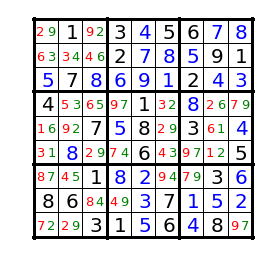

In [233]:
error_index = 0

mpl.rcParams.update({"font.size": 12})

fg, ax = plt.subplots(figsize=(5.5, 4))
row = wrong_preds[error_index]
puzzle = np.where(row[0] < 9, row[0] + 1, 0).reshape(9, 9)
solution = np.where(row[2] < 9, row[2] + 1, 0).reshape(9, 9)
pred = np.where(row[3] < 9, row[3] + 1, 0).reshape(9, 9)
plot_sudoku(puzzle, solution, pred, ax=ax)
fg.tight_layout()
fg.savefig(NOTEBOOK_PATH.joinpath(f"sudoku_error_{error_index}.svg"), bbox_inches="tight")
fg.savefig(NOTEBOOK_PATH.joinpath(f"sudoku_error_{error_index}.svg"), bbox_inches="tight")
fg.savefig(NOTEBOOK_PATH.joinpath(f"sudoku_error_{error_index}.png"), bbox_inches="tight", dpi=300)

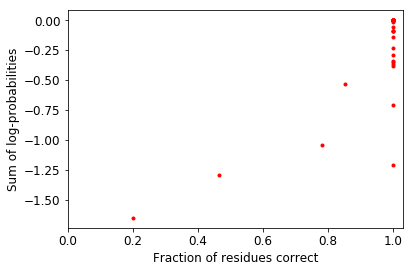

In [55]:
xlim = (0, 1.03)

fg, ax = plt.subplots(figsize=(6, 4))
ax.plot(results_df["fraction_correct"], results_df["sum_log_prob"], 'r.')
ax.set_xlabel("Fraction of residues correct")
ax.set_ylabel("Sum of log-probabilities")
ax.set_xlim(*xlim)
fg.savefig(NOTEBOOK_PATH / "test-incremental-probas.svg")
fg.savefig(NOTEBOOK_PATH / "test-incremental-probas.pdf")
fg.savefig(NOTEBOOK_PATH / "test-incremental-probas.png", dpi=300)

In [199]:
for file in sorted(Path("sudoku_4xEdgeConv_stretch").glob("*.state")):
    print(file)
    net = Net(x_input_size=10, adj_input_size=None, hidden_size=128, output_size=9)
    # net.load_state_dict(torch.load("sudoku_4xEdgeConv_stretch/e0-s7812-d999936-amv09791666666666666.state"))
    net.load_state_dict(torch.load(file))

    net.eval()
    net = net.to(device)

    results = []
    for data in sudoku_dataset_test:
        data = data.to(device)
        x_in = data.x.clone()
        is_missing = x_in == 9
        log_conf_lst = []
        predicted = design_sudoku(net, x_in, data.edge_index, log_conf_lst)
        num_correct = float((predicted[is_missing] == data.y[is_missing]).sum())
        num_total = float(is_missing.sum())
        results.append(
            {
                "fraction_correct": num_correct / num_total,
                "num_correct": num_correct,
                "num_total": num_total,
                "sum_log_prob": np.sum(log_conf_lst),
            }
        )
    results_df = pd.DataFrame(results)
    print(results_df["num_correct"].sum() / results_df["num_total"].sum())

sudoku_4xEdgeConv_stretch/e0-s7812-d999936-amv09791666666666666.state
0.8367346938775511
sudoku_4xEdgeConv_stretch/e1-s15624-d1999872-amv09879943502824858.state
0.8463010204081632
sudoku_4xEdgeConv_stretch/e10-s85932-d10999296-amv09956214689265537.state
0.9272959183673469
sudoku_4xEdgeConv_stretch/e11-s93744-d11999232-amv0996045197740113.state
0.8928571428571429
sudoku_4xEdgeConv_stretch/e12-s101556-d12999168-amv09961158192090396.state
0.8839285714285714
sudoku_4xEdgeConv_stretch/e13-s109368-d13999104-amv09962570621468927.state
0.8641581632653061
sudoku_4xEdgeConv_stretch/e14-s117180-d14999040-amv09959745762711865.state
0.875
sudoku_4xEdgeConv_stretch/e15-s124992-d15998976-amv09961158192090396.state
0.9113520408163265
sudoku_4xEdgeConv_stretch/e16-s132804-d16998912-amv09963276836158192.state
0.8954081632653061
sudoku_4xEdgeConv_stretch/e17-s140616-d17998848-amv09962570621468927.state
0.8730867346938775
sudoku_4xEdgeConv_stretch/e18-s148428-d18998784-amv09961158192090396.state
0.9100765

In [175]:
raise Exception

Exception: 

In [ ]:
@torch.no_grad()
def design_sudoku_2(net, x, x_proba, edge_index, cutoff=-1):
    if x_proba is None:
        x_proba = torch.zeros_like(x).to(torch.float)

    mask = (x == 9)
    if not mask.any():
        return [(x, x_proba)]

    index_array = torch.arange(x.size(0))
    
    output = net(x, edge_index)
    output = torch.softmax(output, dim=1)
    output = output[mask]
    index_array = index_array[mask]

    max_index = output.max(dim=1)[0].max(dim=0)[1]
    max_pred_row = output[max_index]

    sum_log_prob = x_proba.sum()
    assert sum_log_prob.item() <= 0, x_proba

    p_cutoff = min(torch.exp(cutoff - sum_log_prob), max_pred_row.max()).item()
    results = []
    for i, p in enumerate(max_pred_row):
        if p < p_cutoff:
            continue
        x_clone = x.clone()
        x_proba_clone = x_proba.clone()
        assert x_clone[index_array[max_index]] == 9
        x_clone[index_array[max_index]] = i
        x_proba_clone[index_array[max_index]] = torch.log(p)
        result = design_sudoku_2(net, x_clone, x_proba_clone, edge_index)
        results.extend(result)
    return results

In [ ]:
data = sudoku_dataset_test[0].to(device)

In [ ]:
results = design_sudoku_2(net, data.x.clone(), None, data.edge_index)

In [ ]:
results = sorted(((a.data.cpu(), b.data.cpu()) for a, b in results), reverse=True)

In [ ]:
results = []
for data in sudoku_dataset_test:
    data = data.to(device)
    is_missing = data.x == 9
    outputs = design_sudoku_2(net, data.x.clone(), None, data.edge_index, -20)
    outputs = sorted((t for t in outputs), key=lambda t: t[1].sum().item(), reverse=True)
#     results = sorted(((a.data.cpu(), b.data.cpu()) for a, b in results), reverse=True)
    y, y_proba = outputs[0]
    num_correct = float((y[is_missing] == data.y[is_missing]).sum())
    num_total = float(is_missing.sum())
    results.append(
        {
            "fraction_correct": num_correct / num_total,
            "num_correct": num_correct,
            "num_total": num_total,
            "sum_log_prob": torch.sum(y_proba).cpu().item(),
        }
    )
results_df = pd.DataFrame(results)

In [ ]:
xlim = (0, 1.03)

with plt.rc_context(rc={"font.size": 12}):
    fg, ax = plt.subplots(figsize=(6, 4))
    ax.plot(results_df["fraction_correct"], results_df["sum_log_prob"], 'r.')
    ax.set_xlabel("Fraction of residues correct")
    ax.set_ylabel("Sum of log-probabilities")
    ax.set_xlim(*xlim)

In [ ]:
xlim = (0, 1.03)
textstr = """\
Fraction correct overall: {:.4f}
""".format(
    results_df["num_correct"].sum() / results_df["num_total"].sum()
).strip()
props = dict(facecolor="white", alpha=0.3)

with plt.rc_context(rc={"font.size": 12}):
    fg, ax = plt.subplots(figsize=(6, 4))
    data = results_df["fraction_correct"]
    assert data.min() >= xlim[0] and data.max() <= xlim[1]
    ax.hist(data, bins=20)
    ax.set_ylabel("Number of puzzles")
    ax.set_xlabel("Fraction of missing values filled correctly")
    ax.set_xlim(*xlim)
#     ax.set_ylim(0, 5)
    ax.set_title("Test - Incremental")
    ax.text(0.04, 0.95, textstr, transform=ax.transAxes, fontsize="medium", verticalalignment="top", bbox=props)

In [ ]:
@torch.no_grad()
def design_sudoku_3(net, x, x_proba, edge_index, cutoff=-1):
    if x_proba is None:
        x_proba = torch.zeros_like(x).to(torch.float)
    sum_log_prob = x_proba.sum()

    mask = (x == 9)
    if not mask.any():
        return [(x, x_proba)]

    index_array = torch.arange(x.size(0))
    
    output = net(x, edge_index)
    output = output[mask]
    index_array = index_array[mask]

    # Select rows to examine
    output_sum = output.sum(dim=1)
    row_probas = torch.softmax(output_sum, dim=0)
    row_proba_cutoff = min(0.1, row_probas.max())
    index_array_2 = torch.arange(len(row_probas))[row_probas >= row_proba_cutoff][:3]
    
    output = output[index_array_2]
    index_array = index_array[index_array_2]
    
    # Select columns to examine
    output = torch.softmax(output, dim=1)
    
    results = []
    for i, row in enumerate(output):
        p_cutoff = min(torch.exp(cutoff - sum_log_prob), row.max()).item()
        for j, p in enumerate(row):
            if p < p_cutoff:
                continue
            x_clone = x.clone()
            x_proba_clone = x_proba.clone()
            assert x_clone[index_array[i]] == 9
            x_clone[index_array[i]] = i
            x_proba_clone[index_array[i]] = torch.log(p)
            result = design_sudoku_3(net, x_clone, x_proba_clone, edge_index)
            results.extend(result)
    return results

In [ ]:
data = sudoku_dataset_test[0].to(device)

In [ ]:
# results = design_sudoku_3(net, data.x.clone(), None, data.edge_index, -5)

In [ ]:
# results = sorted(((a.data.cpu(), b.data.cpu()) for a, b in results), reverse=True)

In [ ]:
x = torch.arange(4)
x[torch.tensor([0, 0, 0, 1], dtype=torch.uint8)] = 10
x

In [ ]:
torch.tensor([1,2,3], dtype=torch)